In [1]:
import pandas as pd

# 一、train_queries数据集
### sid：会话id
### pid：配置文件id
### req_time：查询时间戳
### o：起始点坐标
### d：终点坐标

## 1.1    数据大小&类型

In [45]:
train_queries = pd.read_csv('data_set_phase1//train_queries.csv')

In [3]:
train_queries.head()

,sid,pid,req_time,o,d
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96"
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79"
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00"
3,559931,202427.0,2018-11-23 14:54:11,"116.27,39.88","116.39,39.90"
4,2819352,172251.0,2018-10-30 11:48:41,"116.34,39.96","116.37,39.86"


In [4]:
train_queries.shape

(500000, 5)

In [5]:
train_queries.dtypes

sid           int64
pid         float64
req_time     object
o            object
d            object
dtype: object

#### 结论：
#### 1、数据中有一个int64类型的数据，一个float64类型的数据，三个object类型数据
#### 2、一共有500000条数据

## 1.2     数据缺失值情况

In [6]:
train_queries.isnull().sum()

sid              0
pid         163979
req_time         0
o                0
d                0
dtype: int64

In [9]:
163979/500000

0.327958

#### 结论：pid存在163979个缺失值，缺失比例为32.7958%

## 1.3  数据nunique的分布

#### nuinque()是查看该序列(axis=0/1对应着列或行)的不同值的数量。用这个函数可以查看数据有多少个不同值。数据nunique的分布的比例，可以判断某一列的特征是否唯一

In [8]:
train_queries.nunique()

sid         500000
pid          46191
req_time    464211
o             5460
d             4923
dtype: int64

In [7]:
train_queries.nunique()/train_queries.shape[0]

sid         1.000000
pid         0.092382
req_time    0.928422
o           0.010920
d           0.009846
dtype: float64

#### 结论：
#### 1、sid是唯一的
#### 2、pid不同值占了9.2382%
#### 3、o和d的不同值分别占了1.092%和0.9846%，说明起始点坐标和终点坐标有很多相同值；大概是相同地点搜索路线的用户有很多，相同起点和相同目的地的用户也很多

## 1.4 o和d探索

In [10]:
train_queries['o'].value_counts()[:5]

116.37,39.86    5993
116.32,39.89    5930
116.42,39.90    5819
116.41,39.91    5616
116.37,39.91    5246
Name: o, dtype: int64

In [11]:
train_queries['d'].value_counts()[:5]

116.32,39.89    16503
116.37,39.86    13124
116.42,39.90    11256
116.39,39.90     7575
116.39,39.91     7571
Name: d, dtype: int64

## 1.4.1  o和d的分布探索

#### 为了对经纬度有个大致了解，将经纬度的信息进行KMeans聚类，并用散点图进行绘制

In [12]:
from sklearn.cluster import KMeans
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

o_x_list = []
o_y_list = []

d_x_list = []
d_y_list = []

# 将经纬度坐标提取出来
for i in range(train_queries.shape[0]):
    o_x_list.append(float(train_queries['o'][i].split(',')[0]))
    o_y_list.append(float(train_queries['o'][i].split(',')[1]))
    
    d_x_list.append(float(train_queries['d'][i].split(',')[0]))
    d_y_list.append(float(train_queries['d'][i].split(',')[1]))
    
o_data = pd.DataFrame.from_dict({'x': o_x_list, 'y': o_y_list})
d_data = pd.DataFrame.from_dict({'x': d_x_list, 'y': d_y_list})

# KMeans聚类
model_o = KMeans(n_clusters=7, init='k-means++', n_init=5)
model_d = KMeans(n_clusters=7, init='k-means++', n_init=5)
y_pre_o = model_o.fit_predict(o_data)
y_pre_d = model_d.fit_predict(d_data)

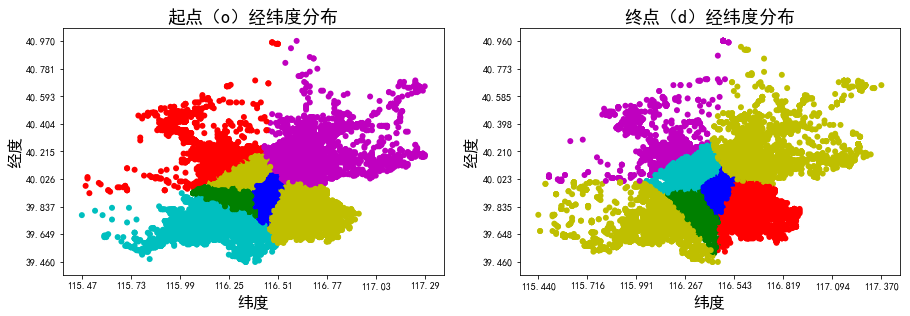

In [13]:
# 画散点图图
def plotScatter(data, y_pre, x_list, y_list):
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    matplotlib.rcParams['axes.unicode_minus'] = False
    cm = matplotlib.colors.ListedColormap(['c','b','r','g','m','y'])
    plt.scatter(data['x'], data['y'], c=y_pre, cmap=cm, edgecolors='none')
    x_min = np.min(x_list)
    x_max = np.max(x_list)
    y_min = np.min(y_list)
    y_max = np.max(y_list)
    plt.xticks(np.linspace(x_min,x_max,8,endpoint=True))
    plt.yticks(np.linspace(y_min,y_max,9,endpoint=True))
    plt.xlabel('纬度', fontsize=16)
    plt.ylabel('经度', fontsize=16)
plt.figure(figsize=(15, 10))
ax1 = plt.subplot(2,2,1)
plotScatter(o_data, y_pre_o, o_x_list, o_y_list)
ax1.set_title('起点（o）经纬度分布', fontsize=18)
ax2 = plt.subplot(2,2,2)
plotScatter(d_data, y_pre_d, d_x_list, d_y_list)
ax2.set_title('终点（d）经纬度分布', fontsize=18)
plt.show()

#### 从上图可以看出，中心区较为密集，多为商场等大型场所，所以点很多；较远区域有很多散点，多为上班族下班回郊区所造成。而且起点（o）的分布与终点（d）的分布类似。

# 二、train_plans数据集
### sid：会话id
### plan_time：计划推荐时间戳
### plans：推荐模式，包括distance(距离m)、price(价格c)、eta(预计所需时间s)、transport_mode(出行模式)

## 2.1  数据类型和大小

In [46]:
train_plans = pd.read_csv('data_set_phase1//train_plans.csv')

In [16]:
train_plans.head()

,sid,plan_time,plans
0,1709112,2018-11-04 11:45:04,"[{""distance"": 32303, ""price"": 600, ""eta"": 5087..."
1,3327773,2018-10-16 19:09:29,"[{""distance"": 3427, ""price"": 300, ""eta"": 627, ..."
2,3285959,2018-11-25 15:05:22,"[{""distance"": 36234, ""price"": 1100, ""eta"": 931..."
3,1616170,2018-10-03 14:42:40,"[{""distance"": 11450, ""price"": 400, ""eta"": 2801..."
4,351369,2018-10-05 19:52:37,"[{""distance"": 18495, ""price"": 600, ""eta"": 4271..."


In [15]:
train_plans.shape

(491054, 3)

In [18]:
train_plans.dtypes

sid           int64
plan_time    object
plans        object
dtype: object

In [17]:
train_plans.isnull().sum()

sid          0
plan_time    0
plans        0
dtype: int64

In [20]:
train_plans.nunique()

sid          491054
plan_time    455427
plans        489563
dtype: int64

#### 结论：
#### 1、数据集总共491054条数据
#### 2、数据集中包含一个int64数据类型，两个object数据类型
#### 3、无缺失值
#### 4、sid唯一，plan_time和plans有不同程度的相同数据

## 2.2  plans分析

#### plans是以list形式存储，读取出来是string类型，所以用eval对plans的类型进行还原，并抽取里面的特征

In [24]:
plans = pd.DataFrame()
for i in range(1000):# train_plans.shape[0]
    sid = train_plans['sid'][i]
    for j in range(len(eval(train_plans['plans'][i]))):
        distance = (eval(train_plans['plans'][i])[j])['distance']
        price = (eval(train_plans['plans'][i])[j])['price']
        eta = (eval(train_plans['plans'][i])[j])['eta']
        transport_mode = (eval(train_plans['plans'][i])[j])['transport_mode']
        plan = {'sid': sid, 'transport_mode': transport_mode, 'distance': distance, 'price': price, 'eta': eta, 'rank': j+1}
        plan_dt = pd.DataFrame.from_dict(plan, orient='index').T
        plans = pd.concat([plans, plan_dt], ignore_index=True)

In [25]:
plans.price[plans['price']=='']=0
plans.head()

,sid,transport_mode,distance,price,eta,rank
0,1709112,9,32303,600,5087,1
1,1709112,3,33678,0,3149,2
2,1709112,4,33678,10000,3269,3
3,1709112,2,32099,600,5996,4
4,1709112,1,30446,900,6494,5


## 2.3  transport_mode猜测

#### 画出每一种transport_mode的平均速度直方图和平均价格直方图，猜测每一种mode是什么

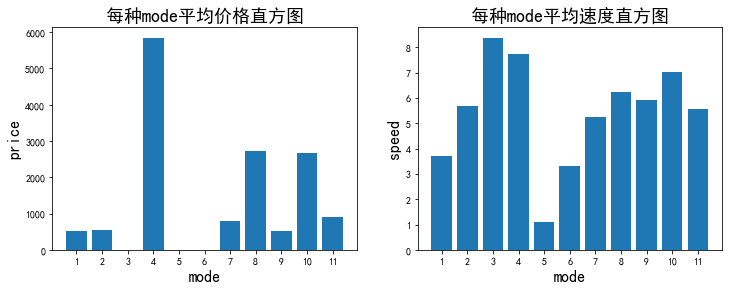

In [26]:
# 计算每种mode的平均价格
p = []
for i in range(11):
    pri = plans.price[plans['transport_mode']==i+1].sum()/len(plans.price[plans['transport_mode']==i+1])
    p.append(pri)
    
# 计算每种mode的平均速度
s = []
for i in range(11):
    speed = plans.distance[plans['transport_mode']==i+1].sum()/plans.eta[plans['transport_mode']==i+1].sum()
    s.append(speed)

# 画直方图
plt.figure(figsize=(12,9))
x_label = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
ax1 = plt.subplot(2,2,1)
ax1.bar(range(len(p)), p, tick_label=x_label)
ax1.set_title('每种mode平均价格直方图', fontsize=18)
ax1.set_xlabel('mode', fontsize=16)
ax1.set_ylabel('price', fontsize=16)

ax2 = plt.subplot(2,2,2)
ax2.bar(range(len(s)), s, tick_label=x_label)
ax2.set_title('每种mode平均速度直方图', fontsize=18)
ax2.set_xlabel('mode', fontsize=16)
ax2.set_ylabel('speed', fontsize=16)
plt.show()

#### 通过观察上图，mode5可能是步行，因为价格为0，速度最慢；mode6可能是自行车，因为价格为0，速度还算可以；mode3可能是自驾，因为价格为0，速度比较快，自己家的车不需要向外支出费用。

## 2.4  train_queries和train_plans中的sid和时间戳探索

#### train_queries和train_plans都存在一个sid和一个时间戳，我们想探索一下sid和时间戳是否有很大差别

In [47]:
q_p = pd.merge(train_queries, train_plans, on='sid')

In [28]:
q_p.head()

,sid,pid,req_time,o,d,plan_time,plans
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96",2018-11-02 17:54:30,"[{""distance"": 5219, ""price"": 300, ""eta"": 1367,..."
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79",2018-11-16 10:53:10,"[{""distance"": 13864, ""price"": 600, ""eta"": 3221..."
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00",2018-10-06 10:33:58,"[{""distance"": 12294, ""price"": 400, ""eta"": 2472..."
3,559931,202427.0,2018-11-23 14:54:11,"116.27,39.88","116.39,39.90",2018-11-23 14:54:11,"[{""distance"": 14853, ""price"": 1700, ""eta"": 291..."
4,2819352,172251.0,2018-10-30 11:48:41,"116.34,39.96","116.37,39.86",2018-10-30 11:48:41,"[{""distance"": 12882, ""price"": 600, ""eta"": 3211..."


In [29]:
q_p.shape

(491054, 7)

In [30]:
# 比较两个时间戳
import datetime
time = []
for i in range(q_p.shape[0]):
    req_time = datetime.datetime.strptime(q_p['req_time'][i], "%Y-%m-%d %H:%M:%S")
    plan_time = datetime.datetime.strptime(q_p['plan_time'][i], "%Y-%m-%d %H:%M:%S")
    time.append(req_time-plan_time)

#### 结论：
#### 1、train_plans中的sid都在train_queries中
#### 2、req_time和plan_time基本上是一样的（99%左右），有个别不一样的情况，可能是因为网速或查询地点有问题

# 三、train_clicks数据集
### sid：会话（id）
### click_time：点击时间
### click_mode：点击模式

## 3.1  数据集大小和类型

In [48]:
train_clicks = pd.read_csv('data_set_phase1//train_clicks.csv')

In [32]:
train_clicks.head()

,sid,click_time,click_mode
0,2848914,2018-11-17 18:42:17,1
1,2629085,2018-10-12 16:28:13,3
2,602598,2018-11-11 16:38:42,2
3,2022975,2018-10-14 12:28:11,9
4,988425,2018-11-12 16:47:30,7


In [33]:
train_clicks.shape

(453336, 3)

In [34]:
train_clicks.dtypes

sid            int64
click_time    object
click_mode     int64
dtype: object

In [35]:
train_clicks.isnull().sum()

sid           0
click_time    0
click_mode    0
dtype: int64

In [36]:
train_clicks.nunique()

sid           453336
click_time    422100
click_mode        11
dtype: int64

#### 结论：
#### 1、数据集一共有453336条数据
#### 2、数据集有两个int类型数据和一个object数据
#### 3、无缺失值
#### 4、sid是唯一的，click_time有6.89%是不唯一的，click_mode总共有11种

## 3.2 标签分布及特点

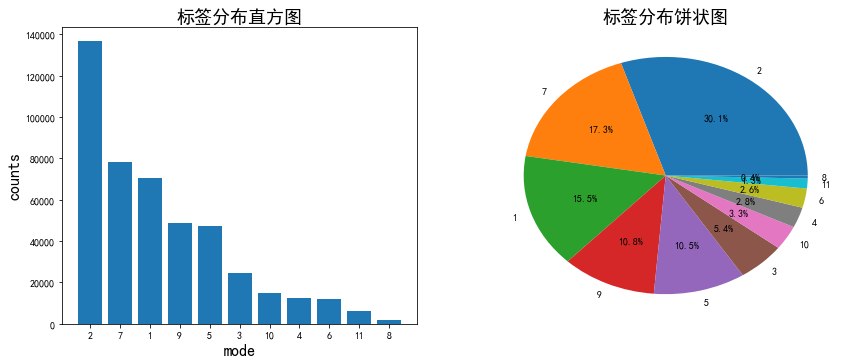

In [48]:
y = train_clicks['click_mode'].value_counts().values
plt.figure(figsize=(14,12))

x_label = ['2', '7', '1', '9', '5', '3', '10', '4', '6', '11', '8']
ax1 = plt.subplot(2,2,1)
ax1.bar(range(len(y)), y, tick_label=x_label)
ax1.set_title('标签分布直方图', fontsize=18)
ax1.set_xlabel('mode', fontsize=16)
ax1.set_ylabel('counts', fontsize=16)

ax2 = plt.subplot(2,2,2)
ax2.pie(y, labels=x_label,autopct='%3.1f%%', shadow=False)
ax2.set_title('标签分布饼状图', fontsize=18)
plt.show()

#### 2、7、1、9、5是最多的；2比7的价格低，而且速度也较快；1比7的价格低，但是速度慢；9的价格相对2、7、1较低，速度相对2、7、1也较快，但选择的人数却相对较少。

## 3.3  细节探索

#### train_queries、train_plans、train_clicks中都有时间戳，查看时间戳是否有差别

In [49]:
q_p_c = pd.merge(q_p, train_clicks, on='sid')

In [50]:
q_p_c.head()

,sid,pid,req_time,o,d,plan_time,plans,click_time,click_mode
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96",2018-11-02 17:54:30,"[{""distance"": 5219, ""price"": 300, ""eta"": 1367,...",2018-11-02 17:54:32,9
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79",2018-11-16 10:53:10,"[{""distance"": 13864, ""price"": 600, ""eta"": 3221...",2018-11-16 10:53:32,1
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00",2018-10-06 10:33:58,"[{""distance"": 12294, ""price"": 400, ""eta"": 2472...",2018-10-06 10:34:23,9
3,559931,202427.0,2018-11-23 14:54:11,"116.27,39.88","116.39,39.90",2018-11-23 14:54:11,"[{""distance"": 14853, ""price"": 1700, ""eta"": 291...",2018-11-23 14:54:18,1
4,2819352,172251.0,2018-10-30 11:48:41,"116.34,39.96","116.37,39.86",2018-10-30 11:48:41,"[{""distance"": 12882, ""price"": 600, ""eta"": 3211...",2018-10-30 11:49:04,7


In [57]:
import datetime
time = []
for i in range(q_p_c.shape[0]):
    req_time = datetime.datetime.strptime(q_p_c['req_time'][i], "%Y-%m-%d %H:%M:%S")
    plan_time = datetime.datetime.strptime(q_p_c['plan_time'][i], "%Y-%m-%d %H:%M:%S")
    click_time = datetime.datetime.strptime(q_p_c['click_time'][i], "%Y-%m-%d %H:%M:%S")
    time.append(click_time-plan_time)

#### 结论：三个时间差距不大，只有个别时间差距比较大，可能是因为网络的问题

# 四、profiles数据集

## 4.1  数据集大小及类型

In [49]:
profiles = pd.read_csv('data_set_phase1//profiles.csv')

In [50]:
profiles.head()

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,196356,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,204083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,170667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,115511,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,129719,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [52]:
profiles.shape

(63090, 67)

In [57]:
profiles.dtypes[:5]

pid      int64
p0     float64
p1     float64
p2     float64
p3     float64
dtype: object

In [61]:
profiles.isnull().sum()[:5]

pid    0
p0     0
p1     0
p2     0
p3     0
dtype: int64

In [63]:
profiles.nunique()[:5]

pid    63090
p0         2
p1         2
p2         2
p3         2
dtype: int64

#### 结论：
#### 1、数据集有63090条数据
#### 2、数据集中只有一个int64类型，其他都为float64类型
#### 3、无缺失值
#### 4、pid是唯一的

# 五、test_queries数据集
### sid：会话id
### pid：配置文件id
### req_time：查询时间戳
### o：起始点坐标
### d：终点坐标

## 5.1 数据集大小及类型

In [14]:
test_queries = pd.read_csv('data_set_phase1//test_queries.csv')

In [15]:
test_queries.head()

,sid,pid,req_time,o,d
0,1126541,178395.0,2018-12-05 14:51:43,"116.41,39.92","116.46,39.95"
1,453685,179178.0,2018-12-01 12:50:33,"116.39,39.90","116.41,39.91"
2,2066073,184748.0,2018-12-07 10:17:35,"116.37,39.71","116.31,39.89"
3,452746,162795.0,2018-12-01 07:52:44,"116.33,39.97","116.31,39.98"
4,1431672,116384.0,2018-12-06 10:36:30,"116.51,39.68","116.51,39.68"


In [16]:
test_queries.shape

(94358, 5)

In [18]:
test_queries.dtypes

sid           int64
pid         float64
req_time     object
o            object
d            object
dtype: object

In [19]:
test_queries.isnull().sum()

sid             0
pid         31447
req_time        0
o               0
d               0
dtype: int64

In [20]:
test_queries.nunique()

sid         94358
pid         13299
req_time    84156
o            3257
d            2884
dtype: int64

#### 结论：
#### 1、数据集中有94358条数据
#### 2、数据集中有一个int64类型和一个float64类型以及三个object类型
#### 3、pid缺失31447条数据，占33.32%
#### 4、sid唯一
#### 5、o和d，与训练集相似，应该是相同地点搜索的用户很多

## 5.2  o和d分布探索

In [27]:
test_queries['o'].value_counts()[:5]

116.32,39.89    1133
116.37,39.86    1059
116.42,39.90    1044
116.37,39.91     985
116.41,39.91     980
Name: o, dtype: int64

In [28]:
test_queries['d'].value_counts()[:5]

116.32,39.89    3382
116.37,39.86    2421
116.42,39.90    2289
116.37,39.91    1345
116.39,39.90    1181
Name: d, dtype: int64

In [22]:
from sklearn.cluster import KMeans
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

o_x_list = []
o_y_list = []

d_x_list = []
d_y_list = []

# 将经纬度坐标提取出来,该部分可进行优化，参考Phase1_BaseLine
for i in range(test_queries.shape[0]):
    o_x_list.append(float(test_queries['o'][i].split(',')[0]))
    o_y_list.append(float(test_queries['o'][i].split(',')[1]))
    
    d_x_list.append(float(test_queries['d'][i].split(',')[0]))
    d_y_list.append(float(test_queries['d'][i].split(',')[1]))
    
o_data = pd.DataFrame.from_dict({'x': o_x_list, 'y': o_y_list})
d_data = pd.DataFrame.from_dict({'x': d_x_list, 'y': d_y_list})

# KMeans聚类
model_o = KMeans(n_clusters=7, init='k-means++', n_init=5)
model_d = KMeans(n_clusters=7, init='k-means++', n_init=5)
y_pre_o = model_o.fit_predict(o_data)
y_pre_d = model_d.fit_predict(d_data)

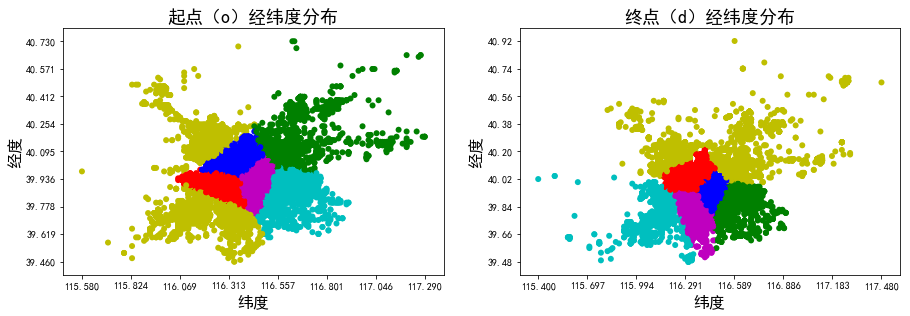

In [23]:
# 画散点图图
def plotScatter(data, y_pre, x_list, y_list):
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    matplotlib.rcParams['axes.unicode_minus'] = False
    cm = matplotlib.colors.ListedColormap(['c','b','r','g','m','y'])
    plt.scatter(data['x'], data['y'], c=y_pre, cmap=cm, edgecolors='none')
    x_min = np.min(x_list)
    x_max = np.max(x_list)
    y_min = np.min(y_list)
    y_max = np.max(y_list)
    plt.xticks(np.linspace(x_min,x_max,8,endpoint=True))
    plt.yticks(np.linspace(y_min,y_max,9,endpoint=True))
    plt.xlabel('纬度', fontsize=16)
    plt.ylabel('经度', fontsize=16)
plt.figure(figsize=(15, 10))
ax1 = plt.subplot(2,2,1)
plotScatter(o_data, y_pre_o, o_x_list, o_y_list)
ax1.set_title('起点（o）经纬度分布', fontsize=18)
ax2 = plt.subplot(2,2,2)
plotScatter(d_data, y_pre_d, d_x_list, d_y_list)
ax2.set_title('终点（d）经纬度分布', fontsize=18)
plt.show()

#### 从上图可以看出，中心区较为密集，多为商场等大型场所，所以点很多；较远区域有很多散点，多为上班族下班回郊区所造成。而且起点（o）的分布与终点（d）的分布类似。

# 六、test_plans数据集
### sid：会话id
### plan_time：计划推荐时间戳
### plans：推荐模式，包括distance(距离m)、price(价格c)、eta(预计所需时间s)、transport_mode(出行模式)

## 6.1 数据集的大小及类型

In [2]:
test_plans = pd.read_csv('data_set_phase1//test_plans.csv')

In [3]:
test_plans.head()

,sid,plan_time,plans
0,1112456,2018-12-05 17:39:47,"[{""distance"": 465, ""price"": """", ""eta"": 418, ""t..."
1,1413458,2018-12-06 17:49:17,"[{""distance"": 28846, ""price"": 600, ""eta"": 4779..."
2,1243160,2018-12-02 14:50:25,"[{""distance"": 24646, ""price"": 600, ""eta"": 3513..."
3,2040494,2018-12-07 09:23:45,"[{""distance"": 32235, ""price"": 600, ""eta"": 4072..."
4,1448779,2018-12-06 18:24:46,"[{""distance"": 13502, ""price"": 400, ""eta"": 3195..."


In [5]:
test_plans.shape

(92571, 3)

In [11]:
test_plans.dtypes

sid           int64
plan_time    object
plans        object
dtype: object

In [12]:
test_plans.isnull().sum()

sid          0
plan_time    0
plans        0
dtype: int64

In [13]:
test_plans.nunique()

sid          92571
plan_time    82432
plans        92163
dtype: int64

#### 结论：
#### 1、数据集一共有92571条数据
#### 2、数据集中有一个int64类型，两个object类型
#### 3、无缺失值
#### 4、sid是唯一的，plan_time和plans有部分相同的

## 6.2 细节探索

#### test_queries和test_plans中都有sid和时间戳

In [29]:
q_p = pd.merge(test_queries, test_plans, on='sid')

In [30]:
q_p.head()

,sid,pid,req_time,o,d,plan_time,plans
0,1126541,178395.0,2018-12-05 14:51:43,"116.41,39.92","116.46,39.95",2018-12-05 14:51:43,"[{""distance"": 13610, ""price"": 400, ""eta"": 2388..."
1,453685,179178.0,2018-12-01 12:50:33,"116.39,39.90","116.41,39.91",2018-12-01 12:50:33,"[{""distance"": 2858, ""price"": 200, ""eta"": 1798,..."
2,2066073,184748.0,2018-12-07 10:17:35,"116.37,39.71","116.31,39.89",2018-12-07 10:17:35,"[{""distance"": 33453, ""price"": 800, ""eta"": 5624..."
3,452746,162795.0,2018-12-01 07:52:44,"116.33,39.97","116.31,39.98",2018-12-01 07:52:44,"[{""distance"": 4007, ""price"": 1500, ""eta"": 989,..."
4,1431672,116384.0,2018-12-06 10:36:30,"116.51,39.68","116.51,39.68",2018-12-06 10:36:30,"[{""distance"": 692, ""price"": """", ""eta"": 591, ""t..."


In [31]:
q_p.shape

(92571, 7)

In [32]:
# 比较两个时间戳
import datetime
time = []
for i in range(q_p.shape[0]):
    req_time = datetime.datetime.strptime(q_p['req_time'][i], "%Y-%m-%d %H:%M:%S")
    plan_time = datetime.datetime.strptime(q_p['plan_time'][i], "%Y-%m-%d %H:%M:%S")
    time.append(req_time-plan_time)

#### 结论：和训练集类似，req_time和plan_time有99%是相同的

# 七、提交格式

In [60]:
submission = pd.read_csv('data_set_phase1//submission_example.csv')

In [61]:
submission.head()

,1126541,2
0,453685,1
1,2066073,7
2,452746,2
3,1431672,5
4,1362848,1


In [63]:
submission.dtypes

1126541    int64
2          int64
dtype: object

#### 官方给的提交格式没有header，需要自己加上去；提交格式有两个int64数据类型，注意提交格式。